<a href="https://colab.research.google.com/github/hiiambobby/NMA_Course/blob/main/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch import nn
from tqdm import tqdm
from torchvision import datasets
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image


In [2]:
#Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
#Hyperparameters
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 15
BATCH_SIZE = 32
LR_RATE = 3e-4  #karpathy constant

dataset = datasets.MNIST(root="dataset/",train = True,transform = transforms.ToTensor(),download = True)
train_loader = DataLoader(dataset = dataset,batch_size = BATCH_SIZE,shuffle = True)


cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.37MB/s]


In [3]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self,input_dim,h_dim,z_dim):
    super().__init__()
    self.img_2hid = nn.Linear(input_dim,h_dim)

    self.hid_2mu = nn.Linear(h_dim,z_dim)
    self.hid_2sigma = nn.Linear(h_dim,z_dim)

    self.z_2hid = nn.Linear(z_dim,h_dim)
    self.hid_2img = nn.Linear(h_dim,input_dim)

    self.relu = nn.ReLU()

  def encode(self,x):
    h = self.relu(self.img_2hid(x))
    mu,sigma = self.hid_2mu(h),self.hid_2sigma(h)
    return mu,sigma

  def decode(self,z):
    new_h = self.relu(self.z_2hid(z))
    return torch.sigmoid(self.hid_2img(new_h))

  def forward(self,x):
    mu, sigma = self.encode(x)
    epsilon = torch.randn_like(sigma)
    z_reparam = mu + sigma*epsilon
    x_reconst = self.decode(z_reparam)
    return x_reconst,mu,sigma # we return all because we need it in kl divergnece


In [4]:
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr = LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

In [5]:
def train(num_epochs, model, optimizer, loss_fn):

  for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for i,(x,_) in loop:
      #forward pass
      x = x.to(DEVICE).view(-1,INPUT_DIM)
      x_reconst,mu,sigma = model(x)
      #loss
      reconstruction_loss = loss_fn(x_reconst,x)
      kl_div= -torch.sum(1+torch.log(sigma.pow(2))-mu.pow(2)-sigma.pow(2))

      #backpropagation
      loss = reconstruction_loss + kl_div
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

          # Update the running loss
      total_loss += loss.item() * x.size(0)

      # Print the epoch loss
  epoch_loss = total_loss / len(train_loader.dataset)
  print("Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss))

In [6]:
# Initialize model, optimizer, loss
model = VariationalAutoEncoder(INPUT_DIM,H_DIM, Z_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

# Run training
train(NUM_EPOCHS, model, optimizer, loss_fn)

Epoch [15/15]: 100%|██████████| 1875/1875 [00:10<00:00, 171.93it/s]

Epoch 15/15: loss=4088.8768


In [15]:
def inference(digit, num_examples=1):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x.to(DEVICE))  # move image to model's device
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    plt.figure(figsize=(num_examples * 2, 2))
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(28, 28).cpu().detach().numpy()


        plt.subplot(1, num_examples, example + 1)
        plt.imshow(out, cmap='gray')
        plt.axis('off')
        plt.title(f'Digit {digit}')

    plt.show()


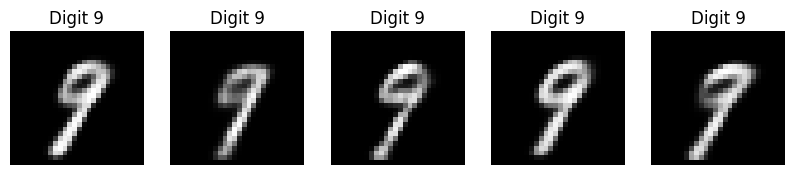

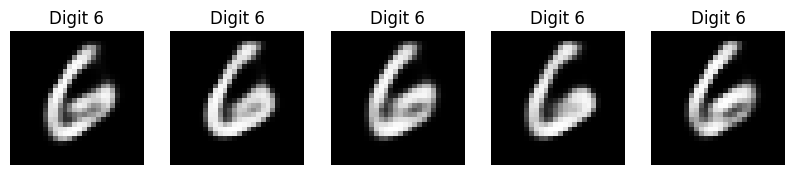

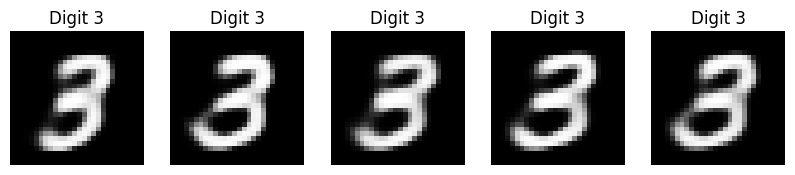

In [17]:
inference(digit=9,num_examples=5)
inference(digit=6,num_examples=5)
inference(digit=3,num_examples=5)